In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 5)

import warnings
warnings.filterwarnings('ignore')

# Boostings

Данные с которыми вы будете работать представляют из себя характеристики клиента страховой компании по которым нужно понять будет ли он заинтересован в страховке. Таким образом, страховая компания может более оптимально таргетить рекламу и выстраивать коммуникацию с клиентами, повышая конверсию.

**Описания колонок:**
- Gender - Male, Female
- Age - Возраст
- Driving_License - Наличие водительского удостоверения
- Region_Code - Область проживания
- Previously_Insured - Пользовался ли раньше услугами страховой компании
- Vehicle_Age - Возраст транспортного средства
- Vehicle_Damage - Попадало ли траспортное средство в ДТП
- Annual_Premium - Ежегодные вылаты клиента
- Policy_Sales_Channel - Политика распространения страховых услуг (через посредников, напрямую и т.д.)
- Vintage - Количество дней, в течение которых rлиент был связан с компанией 


- **Response** - заинтересован в страховке 1, не откликнулся 0

In [17]:
data = pd.read_csv('vehicle_insurance.csv')

data

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,Female,24,1,37.0,1,< 1 Year,No,21243.0,152.0,21,0
9996,Male,28,1,35.0,1,< 1 Year,No,23589.0,160.0,173,0
9997,Female,27,1,15.0,0,< 1 Year,Yes,33340.0,152.0,207,0
9998,Female,28,1,14.0,1,< 1 Year,No,25426.0,152.0,247,0


**Задание 0.** Проведите небольшой EDA. Посмотрите на распределения некоторых колонок, на матрицу корреляций. Также проверьте баланс классов и посмотрите на распределение возраста транспортного средства в зависимости от response. \
Закодируйте признаки типа `object` с помощью `one-hot` кодирования.

P.S. некоторые не `object`колонки по смыслу очевидно являются категориальными. Так как мы будем строить ансамбли на основе деревьев, их можно оставить в первоначальном виде.

In [18]:
from category_encoders.one_hot import OneHotEncoder

df_categorical_col = data.loc[:,data.dtypes==np.object].columns



In [19]:
for col in df_categorical_col:
    onehot = pd.get_dummies(data[col], prefix=col, drop_first=True)
    data = pd.concat((data.drop(col, axis=1), onehot), axis=1)

**Задание 1.** Обучите градиентный бустинг из sklearn на данных и замерьте accuracy и f1-score на тестовой выборке. В качестве параметров ансамбля установите `learning_rate = 1`, `random_state = 1`, `n_estimators = 100`. Изобразите ROC-кривую и посчитайте AUC, оцените качество классификации. (2б)

P.S. для всех прочих моделей в этом домашнем задании тоже фиксируйте `random_state = 1`. Как думаете, что может быть случайного в процедуре обучения градиентного бустинга?

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_curve, auc, RocCurveDisplay

X = data.drop('Response', axis=1)
y = data['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(learning_rate=1,
                                   random_state=1,
                                   n_estimators=100)

model.fit(X_train, y_train)



GradientBoostingClassifier(learning_rate=1, random_state=1)

0.8282350773765659

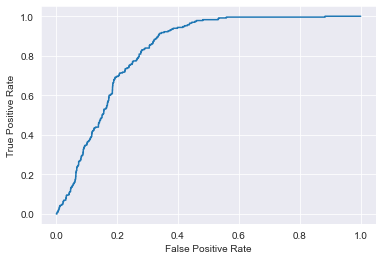

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
auc(fpr, tpr)

**Задание 2.** Переберите параметры `n_estimators` и `learning_rate` по двумерной сетке. При обучении в цикле сразу считайте f1-score на тестовой выборке и сохраняйте результат в матрицу. Для какого алгоритма качество окажется максимальным?

Постройте кривые для метрики f1-score в зависимости от числа шагов для нескольких learning_rate. Изобразите heatmap полученной матрицы. Сделайте вывод, как количество шагов влияет на качество совместно с различной скоростью обучения? (2б)

P.S. для подсчета f1-score передайте в функцию параметр `average='weighted'`, чтобы учитывался еще и баланс классов (вспомните микро/макро-усреднения).

In [12]:
### Задаем сетку параметров

n_estimators_list = [5, 10, 20, 50, 100, 200, 700, 1000]
learning_rate_list = [1, 0.1, 0.01]

In [14]:
for i in n_estimators_list:
    for l in learning_rate_list:
        model = GradientBoostingClassifier(learning_rate=l,
                                   random_state=1,
                                   n_estimators=i)

        model.fit(X_train, y_train)
        print(f'F-мера при {i} и {l} равно: {f1_score(y_test, model.predict(X_test), average="weighted"):.3f}' )





F-мера при 5 и 1 равно: 0.832
F-мера при 5 и 0.1 равно: 0.831
F-мера при 5 и 0.01 равно: 0.831
F-мера при 10 и 1 равно: 0.839
F-мера при 10 и 0.1 равно: 0.831
F-мера при 10 и 0.01 равно: 0.831
F-мера при 20 и 1 равно: 0.842
F-мера при 20 и 0.1 равно: 0.831
F-мера при 20 и 0.01 равно: 0.831
F-мера при 50 и 1 равно: 0.842
F-мера при 50 и 0.1 равно: 0.831
F-мера при 50 и 0.01 равно: 0.831
F-мера при 100 и 1 равно: 0.843
F-мера при 100 и 0.1 равно: 0.832
F-мера при 100 и 0.01 равно: 0.831
F-мера при 200 и 1 равно: 0.841
F-мера при 200 и 0.1 равно: 0.835
F-мера при 200 и 0.01 равно: 0.831
F-мера при 700 и 1 равно: 0.843
F-мера при 700 и 0.1 равно: 0.846
F-мера при 700 и 0.01 равно: 0.831
F-мера при 1000 и 1 равно: 0.841
F-мера при 1000 и 0.1 равно: 0.845
F-мера при 1000 и 0.01 равно: 0.831


**Задание 3.** Вам потребуется обучить 4 модели и посчитать метрику f1-score на тестовой и обучающей выборках для каждой модели. 
1. Случайный лес с максимальной глубиной деревьев 5,
2. Случайный лес с максимальной глубиной деревьев 5000,
3. Градиентный бустинг с максимальной глубиной деревьев 5,
4. Градиентный бустинг с максимальной глубиной деревьев 5000.

Для каждой модели перебирайте значения `n_estimators`, как в предыдущем задании. Отрисуйте графики зависимости f1-score от количества шагов, используя `average='weighted'` для учёта баланса классов. 

Если в качестве базовой модели брать неглубокие деревья, то какая модель лучше запоминает обучающую выборку: случайный лес или градиентный бустинг? Какая из них лучше предсказывает на тестовой выборке? Как изменятся ответы, если базовая модель - это глубокое решающее дерево?

Подвержен ли переобучению случайный лес и градиентный бустинг? Как это отражается на графиках? (4б)

In [21]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
import time
from sklearn.tree import DecisionTreeClassifier

n_estimators_list = [2, 3, 4, 5, 10, 20, 50, 70, 100, 200, 700, 1000, 2000]


for i in n_estimators_list:
    model = RandomForestClassifier(max_depth=5,
                                       random_state=1,
                                       n_estimators=i)
    model.fit(X_train, y_train)
    print(f'F-мера при {i} равно: {f1_score(y_test, model.predict(X_test), average="weighted"):.3f}' )
    %time

F-мера при 2 равно: 0.834
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
F-мера при 3 равно: 0.833
CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs
F-мера при 4 равно: 0.831
CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 2.86 µs
F-мера при 5 равно: 0.833
CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 2.86 µs
F-мера при 10 равно: 0.831
CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 2.15 µs
F-мера при 20 равно: 0.831
CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 2.15 µs
F-мера при 50 равно: 0.831
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 2.86 µs
F-мера при 70 равно: 0.831
CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.86 µs
F-мера при 100 равно: 0.831
CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 1.67 µs
F-мера при 200 равно: 0.831
CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.86 µs
F-мера при 700 равно: 0.831
CPU times

In [22]:
for i in n_estimators_list:
    model = RandomForestClassifier(max_depth=5000,
                                       random_state=1,
                                       n_estimators=i)
    model.fit(X_train, y_train)
    print(f'F-мера при {i} равно: {f1_score(y_test, model.predict(X_test), average="weighted"):.3f}' )
%time

F-мера при 2 равно: 0.847
F-мера при 3 равно: 0.842
F-мера при 4 равно: 0.841
F-мера при 5 равно: 0.839
F-мера при 10 равно: 0.842
F-мера при 20 равно: 0.848
F-мера при 50 равно: 0.845
F-мера при 70 равно: 0.839
F-мера при 100 равно: 0.838
F-мера при 200 равно: 0.838
F-мера при 700 равно: 0.839
F-мера при 1000 равно: 0.839
F-мера при 2000 равно: 0.840
CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 1.91 µs


In [23]:
for i in n_estimators_list:
    model = GradientBoostingClassifier(max_depth=5,
                                       random_state=1,
                                       n_estimators=i)
    model.fit(X_train, y_train)
    print(f'F-мера при {i} равно: {f1_score(y_test, model.predict(X_test), average="weighted"):.3f}' )

F-мера при 2 равно: 0.831
F-мера при 3 равно: 0.831
F-мера при 4 равно: 0.832
F-мера при 5 равно: 0.832
F-мера при 10 равно: 0.832
F-мера при 20 равно: 0.832
F-мера при 50 равно: 0.832
F-мера при 70 равно: 0.834
F-мера при 100 равно: 0.838
F-мера при 200 равно: 0.843
F-мера при 700 равно: 0.843
F-мера при 1000 равно: 0.846
F-мера при 2000 равно: 0.837


In [24]:
for i in n_estimators_list:
    model = GradientBoostingClassifier(max_depth=5000,
                                       random_state=1,
                                       n_estimators=i)
    model.fit(X_train, y_train)
    print(f'F-мера при {i} равно: {f1_score(y_test, model.predict(X_test), average="weighted"):.3f}' )

F-мера при 2 равно: 0.831
F-мера при 3 равно: 0.831
F-мера при 4 равно: 0.831
F-мера при 5 равно: 0.835
F-мера при 10 равно: 0.834
F-мера при 20 равно: 0.835
F-мера при 50 равно: 0.832
F-мера при 70 равно: 0.831
F-мера при 100 равно: 0.833
F-мера при 200 равно: 0.834
F-мера при 700 равно: 0.834
F-мера при 1000 равно: 0.834
F-мера при 2000 равно: 0.834


**Задание 4.** Установите библиотеку `catboost`. Главной особенностью catboost явялется наличие встроенной обработки категориальных признаков. Для каждого категориального столбца вычисляется следующее значение
$$
avg\_target = \dfrac{countInClass + prior}{totalCount + 1},
$$
* countInClass - количество объектов положительного класса для данной категории **до текущего объекта**,
* prior - некоторая константа для числителя, обычно равна доле положительного класса в таргете,
* totalCount - количество наблюдаемых категорий вплоть **до текущего** с той же категорией, что и у текущего.

Так как первые такие значения будут иметь больший разброс, чем последние, то выборку перемешивают несколько раз и полученные статистики усредняют. 
В отличие от target encoder подсчитанные значения зависят от наблюдаемой истории, т.е. вычисляются только из наблюдений до них, таким образом не происходит target leakage. 

Почитать подробнее можно здесь: [Transforming categorical features](https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic)

Обучите CatBoostClassifier с дефолтными параметрами. Используйте датасет до  (разбейте на train/test по старой логике с тем же random state'ом). Категориальные колонки передайте в параметр `cat_features` метода `fit`. Catboost сам с ними разберется.

Сравните качество с моделью из предыдущего задания. Стало ли лучше?

Сравните feature importances в модели из задания 2 и в catboost с помощью соответствующих методов, изобразите их, используя `barplot`. \
Какие признаки стали более важными с новым методом кодирования? (4б)

In [37]:
from catboost import CatBoostClassifier, Pool

catboost = CatBoostClassifier()

df_categorical_col = data.loc[:,data.dtypes==np.object].columns
cols_for_ohe_idx = [list(X_train.columns).index(col) for col in df_categorical_col]

catboost.fit(X_train, y_train, cat_features=cols_for_ohe_idx)

catboost.get_feature_importance(
    Pool(X_train, y_train, cat_features=cols_for_ohe_idx))

pd.DataFrame({'feature_importance': catboost.get_feature_importance(Pool(X_train, y_train, cat_features=cols_for_ohe_idx)),
              'feature_names': X_train.columns}).sort_values(by=['feature_importance'],
                                                           ascending=False)

Learning rate set to 0.025035
0:	learn: 0.6524209	total: 4.46ms	remaining: 4.46s
1:	learn: 0.6213114	total: 8.31ms	remaining: 4.14s
2:	learn: 0.5922961	total: 13ms	remaining: 4.32s
3:	learn: 0.5658834	total: 18.4ms	remaining: 4.58s
4:	learn: 0.5423457	total: 22.8ms	remaining: 4.54s
5:	learn: 0.5180857	total: 27.7ms	remaining: 4.59s
6:	learn: 0.4986798	total: 33.4ms	remaining: 4.74s
7:	learn: 0.4802832	total: 38.5ms	remaining: 4.78s
8:	learn: 0.4619128	total: 43ms	remaining: 4.74s
9:	learn: 0.4465202	total: 48.6ms	remaining: 4.81s
10:	learn: 0.4341692	total: 52.8ms	remaining: 4.75s
11:	learn: 0.4204912	total: 57.3ms	remaining: 4.72s
12:	learn: 0.4147382	total: 62.6ms	remaining: 4.75s
13:	learn: 0.4094293	total: 67.1ms	remaining: 4.73s
14:	learn: 0.3996664	total: 72.6ms	remaining: 4.76s
15:	learn: 0.3902804	total: 76.6ms	remaining: 4.71s
16:	learn: 0.3851970	total: 82ms	remaining: 4.74s
17:	learn: 0.3768978	total: 87.7ms	remaining: 4.78s
18:	learn: 0.3694314	total: 92.2ms	remaining: 4.76

,feature_importance,feature_names
4,27.554321,Previously_Insured
6,21.629688,Vehicle_Damage
1,12.020457,Age
7,9.134945,Annual_Premium
9,8.784024,Vintage
3,8.093579,Region_Code
8,6.214500,Policy_Sales_Channel
5,3.389438,Vehicle_Age
0,3.147194,Gender
2,0.031855,Driving_License


**Задание 5.** Установите библиотеку `lightgbm`. На сегодняшний день это наиболее быстрый метод градиентного бустинга, при этом расходующий небольшое количество оперативной памяти. Достигает он этого за счет построения деревьев вглубь по листьям (leaf-wise), а не по уровням (level-wise), как другие методы, например XGBoost. 
Более понятно это на картинке:

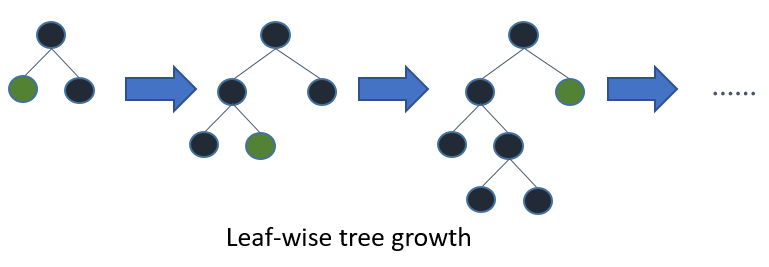

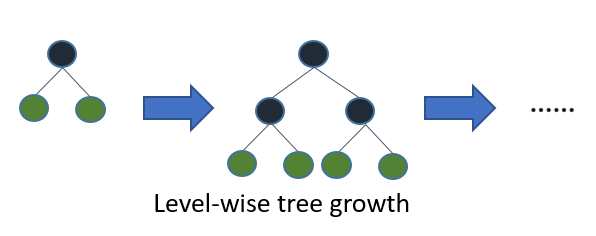

В то время, как XGBoost за раз разделяет вершины на целом уровне той же глубины, LightGBM разделяет одну вершину за раз. Отсюда прирост в скорости.

Обучите `LGBMClassifier` на изначальных(закодированных) данных и добейтесь максимального качества на тестовой выборке, перебрав параметры глубины деревьев, количества шагов, скорости обучения и т.д.

In [22]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

params = {'n_estimators': [100, 500, 1000, 2000],
          'max_depth': [2, 3, 5, 100],
          'learning_rate': [0.1, 0.01, 0.001]}

LGBM = LGBMClassifier()

search = GridSearchCV(LGBM,
                      params,
                      verbose=10)

search.fit(X_train, y_train)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

print(f"Качество лучшей модели на финальном тесте: {search.score(X_test, y_test):.3f}")




Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5; 1/48] START learning_rate=0.1, max_depth=2, n_estimators=100...........
[CV 1/5; 1/48] END learning_rate=0.1, max_depth=2, n_estimators=100;, score=0.873 total time=   0.2s
[CV 2/5; 1/48] START learning_rate=0.1, max_depth=2, n_estimators=100...........
[CV 2/5; 1/48] END learning_rate=0.1, max_depth=2, n_estimators=100;, score=0.873 total time=   0.1s
[CV 3/5; 1/48] START learning_rate=0.1, max_depth=2, n_estimators=100...........
[CV 3/5; 1/48] END learning_rate=0.1, max_depth=2, n_estimators=100;, score=0.872 total time=   0.1s
[CV 4/5; 1/48] START learning_rate=0.1, max_depth=2, n_estimators=100...........
[CV 4/5; 1/48] END learning_rate=0.1, max_depth=2, n_estimators=100;, score=0.873 total time=   0.2s
[CV 5/5; 1/48] START learning_rate=0.1, max_depth=2, n_estimators=100...........
[CV 5/5; 1/48] END learning_rate=0.1, max_depth=2, n_estimators=100;, score=0.873 total time=   0.1s
[CV 1/5; 2/48] START learnin